In [1]:
##### This notebook is an updated version of the following notebook: https://www.kaggle.com/code/shrutidceit/complete-eda

#### This notebook attempts to scan the train dataset thoroughly and perform an exhaustive EDA. In this notebook, I proceeded by 

<ul> 
    <li>Setting the maximum column width to 200</li>
    <li>Importing the dataset</li>
    <li>Checking shapes of the datasets</li>
    <li>Standardizing the column names</li>
    <li>Checking the null values in the dataset and label</li>
    <li>Checking the duplicates in the dataset</li>
    <li>Checking Target leakage in the train dataset</li>
    <li>Checking out for Missing values & basic cleaning</li>
    <li>Exploring <i>subreddit</i> and <i>rule</i> columns</li>
    <li>Create a word cloud for column <b>body</b> for rows where <b>rule_violation = 1</b> and <b>subreddit = "relationships"</b>
</ul>





#### Import libraries

In [2]:
import pandas as pd, numpy as np, re, textwrap, string
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from pathlib import Path


#### Setting the text column characters width to 200

In [161]:
pd.set_option("display.max_colwidth", 200)

#### Load Data

In [162]:
data = Path("../data")

In [163]:
train_path = data/"train.csv"
test_path = data/"test.csv"
sample_submission_path = data/"sample_submission.csv"

In [164]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_submission_path)

#### Checking shapes of the ***train***, ***test*** and ***sample_submission*** datasets

In [165]:
train.shape

(2029, 9)

In [166]:
test.shape

(10, 8)

In [167]:
sample_submission.shape

(10, 2)

#### Standardize column names in ***'train'*** dataset

In [168]:
train.columns = [c.strip().lower() for c in train.columns]
target = "rule_violation"
text_cols = ["body", "rule", "positive_example_1", "positive_example_2", "negative_example_1", "negative_example_2"]
cat_cols = ["subreddit"]
id_cols = ["row_id"]

#### Exploring the ***train*** dataset

In [169]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              2029 non-null   int64 
 1   body                2029 non-null   object
 2   rule                2029 non-null   object
 3   subreddit           2029 non-null   object
 4   positive_example_1  2029 non-null   object
 5   positive_example_2  2029 non-null   object
 6   negative_example_1  2029 non-null   object
 7   negative_example_2  2029 non-null   object
 8   rule_violation      2029 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 142.8+ KB


In [170]:
train.sample(5, random_state=42)

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
1356,1356,All people visit your sister therein such a tits! http://codimenu.com/ac/16php,"No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.",funny,49 http://MySexFind.com - find girl for sex now 49!,FindSexToday . com - free girls for sex worldwide 3oBKmqU6XiS14!,SD Stream [Spanish Stream](http://www.expresssports.ml/p/adsbygoogle-window_146.html) \nMobile : Not Compatible,Here's the link. \n\nhttp://www.powerhousetradingsystem.com/trading.html,1
984,984,Try and see if someone at www.siddhantayoga.com can help you ...,"No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.",SuicideWatch,Ray-Ban Sunglasses Special Sale at $24.99 Shop Now >>> http://www.rbsclassic.com,Help my mans get to 500 dollars\nhttp://referdone.com/?share=10399,If anyone is interested in donating 5 or 10 bucks https://timcanova.com/,"Same shit happened to me man. EXACT same thing, so it's probably AmWay. They got that procedure down pat, probably because it works so well. At the end, I tried to reason with the guy because h...",0
859,859,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/STREAM:\n\nhttp://music.theblacksmithed.com/download/birds/","No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.",movies,My pecker tried best holes at this point now you win this prize http://hothor.se/1xqhk,Trying to raise some funds on PayPal for a boob job any donations appreciated 1-100 I'm up for anything have loads of pictures and videos to share also just about to shower so can take more 😘😘 I'm...,How to Record Android or IPhone Screen Without Rooted Devices . Full Tutorial Watch here https://m.youtube.com/watch?v=FyD2MYbSnKE,SD Stream Eng - [Chelsea TV USA](http://soccerstreamsarena.com/chelsea-u23-vs-tottenham-u23-live-epl2-09-sep-2016/) \n\nMobile : Compatible With Android Puffin Browser,0
1983,1983,WWW.CSGOPOT.COM USE PROMO: CSGOPOTPRO FOR FREE DIAMONDS WWW.CSGOPOT.COM,"No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.",GlobalOffensive,**Dortmund vs Real Madrid Live Stream**\n\n**<<< http://www.dortmund-vs-realmadrid-live.cf >>>**\n\n**HD Quality Streams**\n\n**<<< http://www.dortmund-vs-realmadrid-live.cf >>>**\n\n**HD SOUND Qu...,Selling Tyrande code for 3€ to paypal. PM if interested.\n\nProof of satisfied Tyrande owners: http://imgur.com/a/jydZ7 http://imgur.com/a/jIQGQ\n,"Ive got an Bayonet | Damascus Steel ft, if your're interested \n\nhttps://steamcommunity.com/tradeoffer/new/?partner=215103279&token=fCan2TeW","Shameless plug for our Facebook page, all home made memes https://www.facebook.com/IMakeBleachAndDrinkMemes",1
1293,1293,#stop deleting comments. What you did was fraud.\nhttps://sli.mg/3GGiCy,No legal advice: Do not offer or request legal advice.,The_Donald,Well first you have to figure out if there is even a way that you can do such an agreement and you have to talk to a lawyer about that.,"Maybe true, but that's very short-sighted. The lawsuits are already in the hundreds though on this. He's going to be getting sued six ways to sunset for his entire term. The Constitution offers ve...","> Yeah she initiated it **when I was sleeping**\n\nThat's certainly the unambiguous part of the story. Sexual assault, no gray area.\n\n","If it's *only* killing sick, elderly people - isn't it kind of... alright?",0


In [171]:
train[target].value_counts(dropna=False).to_frame("count").assign(pct=lambda t: t["count"]/len(train))

,count,pct
rule_violation,,
1,1031,0.508132
0,998,0.491868


In [172]:
train.isna().mean().sort_values(ascending=False)

row_id                0.0
body                  0.0
rule                  0.0
subreddit             0.0
positive_example_1    0.0
positive_example_2    0.0
negative_example_1    0.0
negative_example_2    0.0
rule_violation        0.0
dtype: float64

#### Let's count how many rows are exact duplicates of earlier rows in all columns.

In [173]:
train.duplicated().sum()

np.int64(0)

#### Let's counts how many times the same ***row ID*** appears more than once

In [174]:
train[id_cols[0]].duplicated().sum()

np.int64(0)

#### Checking Target leakage in the train dataset

##### Hard leakage

In [175]:
matches = 0

for col in ["positive_example_1", "positive_example_2", "negative_example_1", "negative_example_2"]:
    matches += train.merge(
        train[["row_id", col]].rename(columns = {col:"x"}),
        left_on = "body",
        right_on = "x",
        how = "inner"
    ).shape[0]

matches

12902

##### Soft Leakage

In [176]:
# top_ngrams() is defined to find the most frequent n-grams
def top_ngrams(texts, ngram_range = (2,2), topk=2000): 
    v = CountVectorizer(ngram_range=ngram_range, min_df=2) # min_df=2 means it only include phrases that appear in at least 2 documents
    X = v.fit_transform(texts)
    freqs = np.asarray(X.sum(0)).ravel()
    order = freqs.argsort()[::-1][:topk]
    vocab = np.array(sorted(v.vocabulary_.items(), key=lambda kv:kv[1]))[:, 0]
    return set(vocab[order])

body_bi = top_ngrams(train["body"].fillna(""),(2,2), 3000)
ex_all = pd.Series(train[text_cols[1:]].fillna("").agg(" ".join, axis=1))
ex_bi = top_ngrams(ex_all, (2,2), 3000)
len(body_bi & ex_bi )


1776

#### Checking out for Missing values & basic cleaning

In [177]:
# How often each text field is empty/whitespace

def empty_rate(s): 
    return s.fillna("").str.strip().eq("").mean()

pd.Series({c: empty_rate(train[c]) for c in text_cols + cat_cols})

body                  0.0
rule                  0.0
positive_example_1    0.0
positive_example_2    0.0
negative_example_1    0.0
negative_example_2    0.0
subreddit             0.0
dtype: float64

In [178]:
# normalize() creates Simple normalized versions for analysis

def normalize(s):
    s = s.fillna("").str.replace(r"\s+", " ", regex=True).str.strip()                           
                    # Replace NaN/None with empty string 
                    # Replace multiple whitespace (spaces, tabs, newlines) with a single space
                    # Remove leading and trailing spaces
    return s

for c in text_cols:
    train[c+"_clean"] = normalize(train[c])

train["subreddit"] = train["subreddit"].astype("category")

#### Exploring Columns

##### *I] subreddit*

In [179]:
sub_counts = train["subreddit"].value_counts().to_frame("count")
sub_counts.head(20)


,count
subreddit,
legaladvice,213
AskReddit,152
soccerstreams,139
personalfinance,125
relationships,106
The_Donald,94
TwoXChromosomes,87
news,65
movies,56


In [180]:
# Calculating how often rule violations happen in each subreddit - only for subreddits that have enough data to be meaningful

tmp = (train.groupby("subreddit")[target]
         .agg(["count","mean"])
         .rename(columns={"mean":"violation_rate"})
         .query("count >= 30")
         .sort_values("violation_rate", ascending=False))

tmp.head(20)

/var/folders/p0/bs5mtjhd6016xb_dz27dp3t00000gn/T/ipykernel_36283/2641016486.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (train.groupby("subreddit")[target]


,count,violation_rate
subreddit,,
sex,42,0.809524
legaladvice,213,0.788732
personalfinance,125,0.696000
relationships,106,0.613208
politics,49,0.591837
news,65,0.584615
pics,30,0.566667
The_Donald,94,0.553191
AskReddit,152,0.480263


##### *II] rule*

In [181]:
rule_counts = (train["rule"].fillna("NA").value_counts()
               .to_frame("count")
               .assign(pct=lambda t: t["count"]/len(train)))

rule_counts.head(20)

,count,pct
rule,,
No legal advice: Do not offer or request legal advice.,1017,0.501232
"No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.",1012,0.498768


In [182]:
# Violation rate per rule (for rules with support)
rule_stats = (train.assign(rule=train["rule"].fillna("NA"))
                .groupby("rule")[target]
                .agg(["count","mean"])
                .rename(columns={"mean":"violation_rate"})
                .query("count >= 20")
                .sort_values("violation_rate", ascending=False))
rule_stats.head(20)

,count,violation_rate
rule,,
No legal advice: Do not offer or request legal advice.,1017,0.583088
"No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.",1012,0.432806


In [183]:
# /kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
# /kaggle/input/jigsaw-agile-community-rules/train.csv
# /kaggle/input/jigsaw-agile-community-rules/test.csv

In [184]:
!pip install wordcloud


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


#### Create a word cloud for column ***body*** for rows where ***rule_violation = 1*** and ***subreddit = "relationships"***

In [185]:
from wordcloud import WordCloud, STOPWORDS

# Filtering out rows where rule violations = 1 and subreddit = legal advice
mask = (train["rule_violation"]==1) & (train["subreddit"].str.lower()=="relationships")
filtered_text = train.loc[mask, "body"].dropna()

# Let's join the filtered_text into one string
text_combined = " ".join(filtered_text)

# Define stopwords
stopwords = set(STOPWORDS)

# Create WordCloud

wc = WordCloud(
    width = 1000,
    height = 600,
    background_color="white",
    stopwords=stopwords,
    colormap="viridis"
).generate(text_combined)

#### Displaying the word cloud

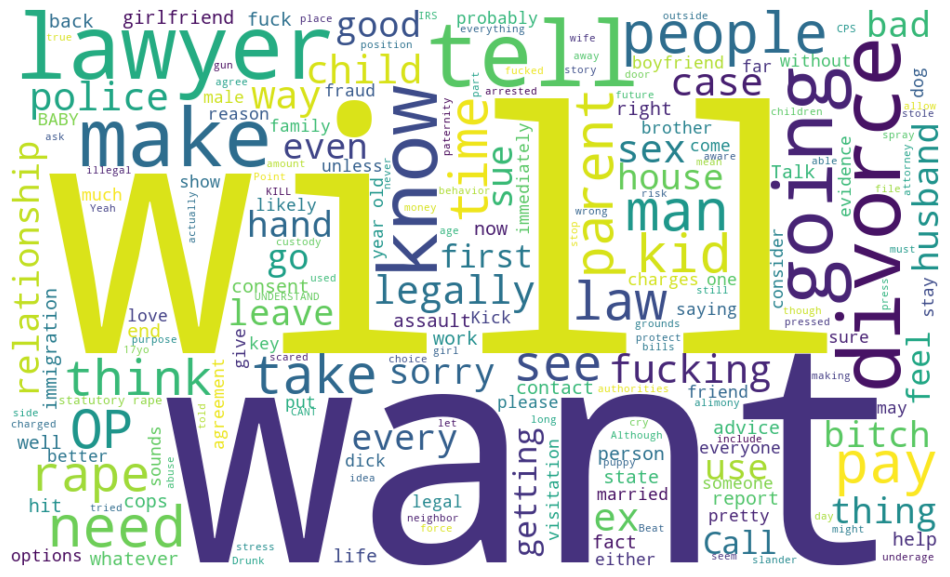

In [186]:
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()